Using device: cuda

=== Fold 1/5 ===

Epoch 1/10
 [██████████████████████████████] 100.0%
Train Loss: 116.4961 | Train Acc: 0.6043
Validation Acc: 0.6241

Epoch 2/10
 [██████████████████████████████] 100.0%
Train Loss: 113.1809 | Train Acc: 0.6233
Validation Acc: 0.6358

Epoch 3/10
 [██████████████████████████████] 100.0%
Train Loss: 112.6432 | Train Acc: 0.6287
Validation Acc: 0.6292

Epoch 4/10
 [██████████████████████████████] 100.0%
Train Loss: 112.2892 | Train Acc: 0.6296
Validation Acc: 0.6433

Epoch 5/10
 [██████████████████████████████] 100.0%
Train Loss: 111.5985 | Train Acc: 0.6363
Validation Acc: 0.6367

Epoch 6/10
 [██████████████████████████████] 100.0%
Train Loss: 108.9070 | Train Acc: 0.6550
Validation Acc: 0.6853

Epoch 7/10
 [██████████████████████████████] 100.0%
Train Loss: 104.3136 | Train Acc: 0.6851
Validation Acc: 0.7068

Epoch 8/10
 [██████████████████████████████] 100.0%
Train Loss: 102.3410 | Train Acc: 0.7004
Validation Acc: 0.7185

Epoch 9/10
 [█████████████

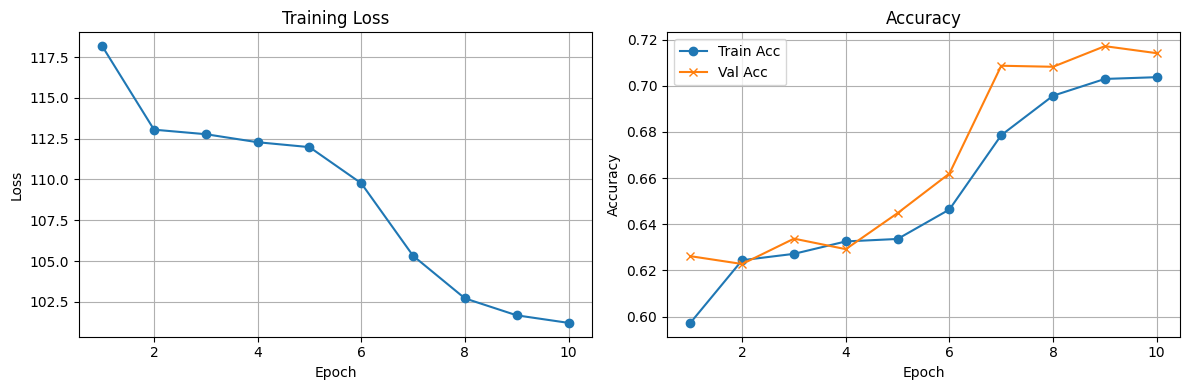


=== Final Evaluation on Test Data ===

Test Metrics:
Accuracy : 0.7134
F1 Score : 0.7201
Precision: 0.7048
Recall   : 0.7362
AUC      : 0.7793


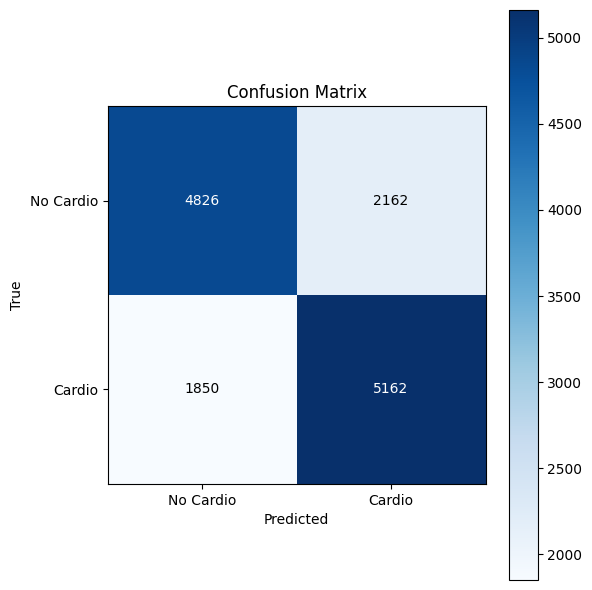

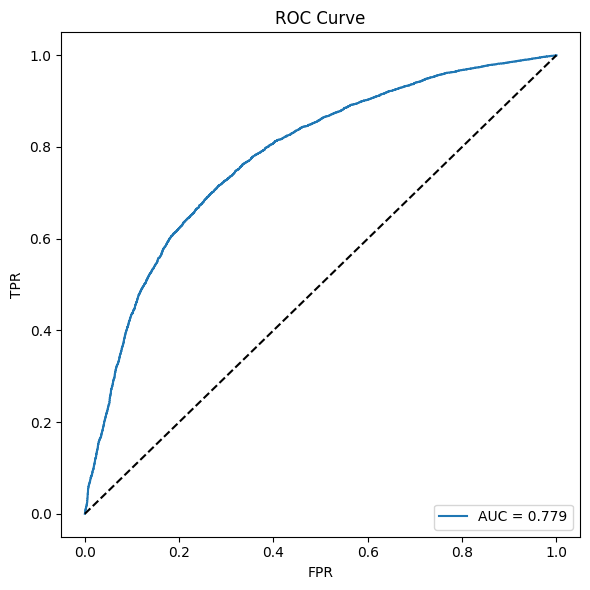

In [ ]:
# K-CV法を用いた心疾患予測モデルの学習と評価
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, roc_curve,
    confusion_matrix
)
import numpy as np
import sys
import matplotlib.pyplot as plt

# --------------------------------------------
# 定数設定
# --------------------------------------------
EPOCHS = 10
THRESHOLD = 0.73
BATCH_SIZE = 256
K_FOLDS = 5

# --------------------------------------------
# 0. デバイス設定
# --------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------------------------
# 1. データ読み込み & 前処理
# --------------------------------------------
data = pd.read_csv("cardio_train.csv", sep=';')
data['BMI'] = data['weight'] / ((data['height'] / 100) ** 2)
data['age_years'] = (data['age'] / 365).astype(int)

categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
continuous_cols  = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']
target_col       = 'cardio'

# ラベルエンコーディング
for col in categorical_cols:
    data[col] = LabelEncoder().fit_transform(data[col])

# 標準化
scaler = StandardScaler()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])

# --------------------------------------------
# 2. Dataset クラス定義
# --------------------------------------------
class CardioDataset(Dataset):
    def __init__(self, df):
        self.categ  = df[categorical_cols].values.astype(np.int64)
        self.cont   = df[continuous_cols].values.astype(np.float32)
        self.labels = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.categ[idx], dtype=torch.int64),
            torch.tensor(self.cont[idx],  dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32),
        )

# --------------------------------------------
# 3. データ分割 (Train+Val / Test = 80/20)
# --------------------------------------------
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
test_loader = DataLoader(CardioDataset(test_data), batch_size=BATCH_SIZE, shuffle=False)

# --------------------------------------------
# 4. 学習・検証ループ用関数定義
# --------------------------------------------
def train_with_validation(model, train_loader, val_loader, epochs, threshold):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    loss_history, train_acc_history, val_acc_history = [], [], []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        print(f"\nEpoch {epoch}/{epochs}")
        for batch_idx, (x_cat, x_cont, y) in enumerate(train_loader, 1):
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x_cat, x_cont).squeeze(1)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            correct += (pred == y.int()).sum().item()
            total += y.size(0)
            # 進捗バー
            progress = batch_idx / len(train_loader) * 100
            bar_len = 30
            filled = int(bar_len * progress / 100)
            bar = '█' * filled + '-' * (bar_len - filled)
            sys.stdout.write(f"\r [{bar}] {progress:5.1f}%")
            sys.stdout.flush()

        loss_history.append(total_loss)
        train_acc = correct / total
        train_acc_history.append(train_acc)
        print(f"\nTrain Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f}")

        # 検証
        model.eval()
        val_preds, val_trues = [], []
        with torch.no_grad():
            for x_cat_v, x_cont_v, y_v in val_loader:
                x_cat_v, x_cont_v, y_v = x_cat_v.to(device), x_cont_v.to(device), y_v.to(device)
                out_v = model(x_cat_v, x_cont_v).squeeze(1)
                prob_v = torch.sigmoid(out_v)
                pred_v = (prob_v > 0.5).int()
                val_preds.extend(pred_v.cpu().tolist())
                val_trues.extend(y_v.cpu().int().tolist())

        val_acc = accuracy_score(val_trues, val_preds)
        val_acc_history.append(val_acc)
        print(f"Validation Acc: {val_acc:.4f}")

        if val_acc >= threshold:
            print(f"Threshold {threshold:.4f} reached at epoch {epoch}. Stopping training.")
            break

    return loss_history, train_acc_history, val_acc_history

def evaluate_model(model, loader):
    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            out = model(x_cat, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            preds.extend(pred.cpu().tolist())
            trues.extend(y.cpu().int().tolist())
            probs.extend(prob.cpu().tolist())

    print("\nTest Metrics:")
    print(f"Accuracy : {accuracy_score(trues, preds):.4f}")
    print(f"F1 Score : {f1_score(trues, preds):.4f}")
    print(f"Precision: {precision_score(trues, preds):.4f}")
    print(f"Recall   : {recall_score(trues, preds):.4f}")
    print(f"AUC      : {roc_auc_score(trues, probs):.4f}")

def plot_confusion_and_roc(model, loader):
    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for x_cat, x_cont, y in loader:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
            out = model(x_cat, x_cont).squeeze(1)
            prob = torch.sigmoid(out)
            pred = (prob > 0.5).int()
            preds.extend(pred.cpu().tolist())
            trues.extend(y.cpu().int().tolist())
            probs.extend(prob.cpu().tolist())

    cm = confusion_matrix(trues, preds)
    classes = ['No Cardio', 'Cardio']
    fpr, tpr, _ = roc_curve(trues, probs)
    auc = roc_auc_score(trues, probs)

    # 混同行列
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(classes))); ax.set_xticklabels(classes)
    ax.set_yticks(np.arange(len(classes))); ax.set_yticklabels(classes)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title('Confusion Matrix')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i,j], ha='center', va='center',
                    color='white' if cm[i,j] > cm.max()/2 else 'black')
    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    # ROC曲線
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0,1],[0,1], 'k--')
    plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.legend(loc='lower right'); plt.tight_layout()
    plt.show()

# --------------------------------------------
# 5. K-Fold Cross Validation
# --------------------------------------------
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_data), 1):
    print(f"\n=== Fold {fold}/{K_FOLDS} ===")
    train_df = train_val_data.iloc[train_idx].reset_index(drop=True)
    val_df   = train_val_data.iloc[val_idx].reset_index(drop=True)

    train_loader = DataLoader(CardioDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(CardioDataset(val_df),   batch_size=BATCH_SIZE, shuffle=False)

    # モデル初期化
    cont_mean_std = torch.tensor([[0., 1.]] * len(continuous_cols)).to(device)
    model = TabTransformer(
        categories=tuple(data[col].nunique() for col in categorical_cols),
        num_continuous=len(continuous_cols),
        dim=32, dim_out=1, depth=4, heads=4,
        attn_dropout=0.1, ff_dropout=0.1,
        mlp_hidden_mults=(4, 2), mlp_act=nn.ReLU(),
        continuous_mean_std=cont_mean_std
    ).to(device)
    model.categories_offset = model.categories_offset.to(device)

    _, _, val_accs = train_with_validation(model, 
DataLoader(CardioDataset(train_df), batch_size=BATCH_SIZE, shuffle=True),
DataLoader(CardioDataset(val_df),   batch_size=BATCH_SIZE, shuffle=False),
EPOCHS, THRESHOLD)
    fold_scores.append(val_accs[-1])

mean_acc = np.mean(fold_scores)
std_acc  = np.std(fold_scores)
print(f"\nK-Fold CV Result (K={K_FOLDS}): Mean Val Acc = {mean_acc:.4f}, Std = {std_acc:.4f}")

# --------------------------------------------
# 6. 全訓練データでの最終学習 → 履歴取得
# --------------------------------------------
final_train_df, final_val_df = train_test_split(train_val_data, test_size=0.2, random_state=42)
final_train_loader = DataLoader(CardioDataset(final_train_df), batch_size=BATCH_SIZE, shuffle=True)
final_val_loader   = DataLoader(CardioDataset(final_val_df),   batch_size=BATCH_SIZE, shuffle=False)

cont_mean_std = torch.tensor([[0., 1.]] * len(continuous_cols)).to(device)
final_model = TabTransformer(
    categories=tuple(data[col].nunique() for col in categorical_cols),
    num_continuous=len(continuous_cols),
    dim=32, dim_out=1, depth=4, heads=4,
    attn_dropout=0.1, ff_dropout=0.1,
    mlp_hidden_mults=(4, 2), mlp_act=nn.ReLU(),
    continuous_mean_std=cont_mean_std
).to(device)
final_model.categories_offset = final_model.categories_offset.to(device)

loss_history, train_acc_history, val_acc_history = train_with_validation(
    final_model, final_train_loader, final_val_loader, EPOCHS, THRESHOLD
)

# --------------------------------------------
# 7. 学習曲線プロット
# --------------------------------------------
def plot_training_curves(losses, train_accs, val_accs):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o')
    plt.title('Training Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, marker='o', label='Train Acc')
    plt.plot(epochs, val_accs,   marker='x', label='Val Acc')
    plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plot_training_curves(loss_history, train_acc_history, val_acc_history)

# --------------------------------------------
# 8. テストデータで最終評価 + 可視化
# --------------------------------------------
print("\n=== Final Evaluation on Test Data ===")
evaluate_model(final_model, test_loader)
plot_confusion_and_roc(final_model, test_loader)
